This notebook shows that how the stable rank and distance preservation properies of these embedders differs.

In [1]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy


file_path = 'images/'

In [2]:
def srank_func(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    sr = (s*s).sum()/s[0]/s[0]
    return sr

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def rff_embedding(x, b):
    emb = np.concatenate((np.sin((2.*np.pi*x) @ b.T),np.cos((2.*np.pi*x) @ b.T)),1)
    return emb

def impulse_embedding(x, b, s=5e-5):
    emb = (abs(x-b)<=s).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def square_embedding(x, b, f=1):
    emb = (torch.sin(2.*np.pi*f*(x-b))>0).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def shift_embedding(x, c):
    all_emb = scipy.linalg.circulant(c)
    idx = (x*all_emb.shape[0]).int().squeeze()
    emb = torch.from_numpy(all_emb[idx]).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()
    

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

# stable rank & distance preservation

In [3]:
Large_D = 10000
Ns = range(1,51,1)
sr_ = np.zeros((5,len(Ns)))
cr_ = np.zeros((5,Large_D))

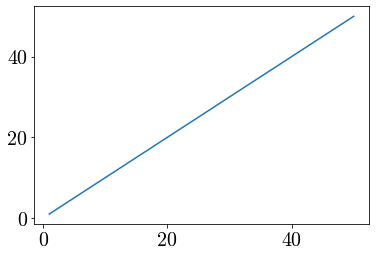

In [136]:
# impulse
c = np.zeros((Large_D,))
c[0] = 1
c = c/np.linalg.norm(c)
all_emb = scipy.linalg.circulant(c)
for i in range(Large_D):
    cr_[0][i] = np.sum(all_emb[i]*all_emb[5000])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[0][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[0])

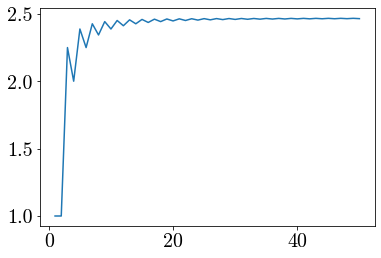

In [146]:
# square
f = 1
c = (np.sin(2.*np.pi*f*np.linspace(0, 1, Large_D+1)[:-1])>0)*2-1
c = c/np.linalg.norm(c)
all_emb = scipy.linalg.circulant(c)
for i in range(Large_D):
    cr_[1][i] = np.sum(all_emb[i]*all_emb[5000])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[1][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[1])

random nonise
c = np.random.randn(Large_D)
c = c/np.linalg.norm(c)
all_emb = scipy.linalg.circulant(c)
for i in range(Large_D):
    cr_[2][i] = np.sum(all_emb[i]*all_emb[0])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[2][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[2])

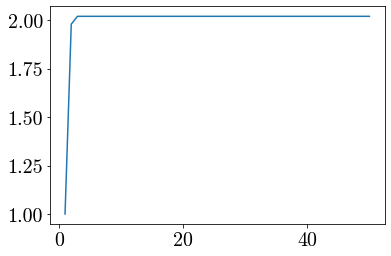

In [138]:
# sin
f = 1
c = np.sin(2.*np.pi*f*np.linspace(0, 1, Large_D+1)[:-1])+0.7
c = c/np.linalg.norm(c)
all_emb = scipy.linalg.circulant(c)
for i in range(Large_D):
    cr_[2][i] = np.sum(all_emb[i]*all_emb[5000])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[2][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[2])

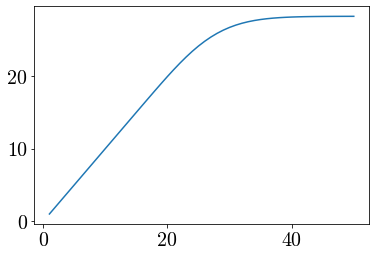

In [139]:
sig = 0.01
c = np.exp(-0.5*(np.linspace(0, 1, Large_D+1)[:-1]-0.5)**2/sig**2)
c = c/np.linalg.norm(c)
all_emb = scipy.linalg.circulant(c)
for i in range(Large_D):
    cr_[3][i] = np.sum(all_emb[i]*all_emb[5000])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[3][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[3])

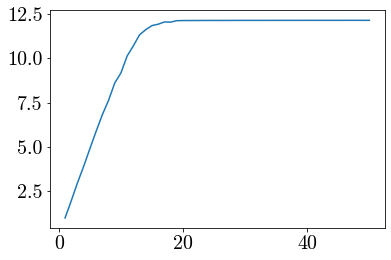

In [140]:
b0 = 5
b = b0*torch.randn((int(Large_D/2),1))
x0 = torch.from_numpy(np.linspace(0, 1, Large_D+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
all_emb = rff_embedding(x0,b)/np.sqrt(Large_D/2)
for i in range(Large_D):
    cr_[4][i] = np.sum(all_emb[i]*all_emb[5000])
for i in range(len(Ns)):
    x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
    idx = (x*all_emb.shape[0]).int().squeeze()
    sr_[4][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))
plot(Ns,sr_[4])

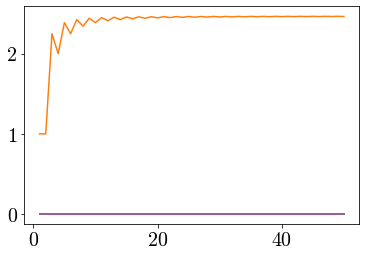

In [147]:
for i in range(5):
    plot(Ns,sr_[i])

/home/jianqiao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jianqiao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


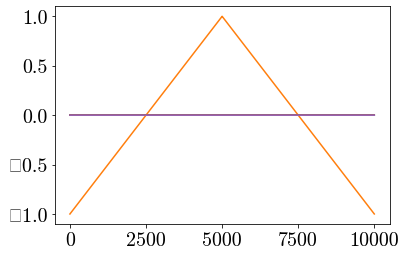

In [148]:
for i in range(5):
    plot(cr_[i])

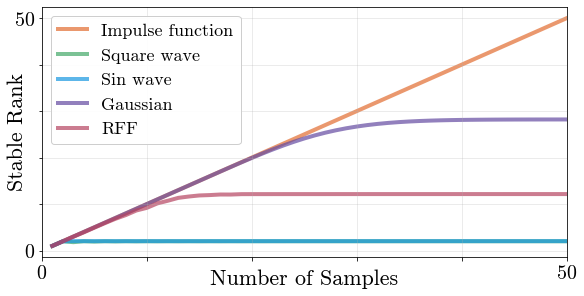

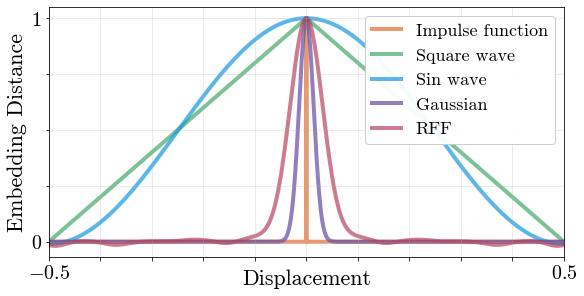

In [143]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     #[0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

names = ['Impulse function','Square wave','Sin wave','Gaussian','RFF']


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(5):
    ax.plot(Ns,sr_[i],label=names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks([0,10,20,30,40,50])
ax.set_yticklabels(['$0$','','','','','$50$'])
ax.set_xticks([0,10,20,30,40,50])
ax.set_xticklabels(['$0$','','','','','$50$'])
plt.xlabel('Number of Samples', labelpad=-13)
plt.ylabel('Stable Rank', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='upper left',  ncol=1, framealpha=.95, handlelength=1.6)
#ax.set_title('(a) Stable Rank', y=title_offset)

plt.savefig(file_path+'Compare_all_sr.pdf', bbox_inches='tight', pad_inches=0)


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(5):
    ax.plot(np.linspace(0, 1, Large_D+1)[:-1].reshape(-1,1)-0.5,cr_[i],label=names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks(np.linspace(0,1,5))
ax.set_yticklabels(['$0$']+['']+['']+['']+['$1$'])
ax.set_xticks(np.linspace(-0.5,0.5,11))
ax.set_xticklabels(['$-0.5$']+['']*4+['']+['']*4+['$0.5$'])
plt.xlabel('Displacement', labelpad=-13)
plt.ylabel('Embedding Distance')
plt.grid(True, which='both', alpha=.3)

ax.legend(loc='upper right',  ncol=1, framealpha=.95, handlelength=1.6)

#ax.set_title('(b) Distance Preservation', y=title_offset)

plt.savefig(file_path+'Compare_all_dp.pdf', bbox_inches='tight', pad_inches=0)

In [144]:
Large_D = 10000
Ns = list(range(1,101,5))+list(range(201,521,20))
sigs = [0.1,0.05,0.01,0.005,0.001]
Nf = len(sigs)
sr_ = np.zeros((Nf,len(Ns)))
cr_ = np.zeros((Nf,Large_D))

In [130]:
for k in range(Nf):
    sig = sigs[k]
    c = np.exp(-0.5*(np.linspace(0, 1, Large_D+1)[:-1]-0.5)**2/sig**2)
    c = c/np.linalg.norm(c)
    all_emb = scipy.linalg.circulant(c)
    for i in range(Large_D):
        cr_[k][i] = np.sum(all_emb[i]*all_emb[5000])
    for i in range(len(Ns)):
        x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
        idx = (x*all_emb.shape[0]).int().squeeze()
        sr_[k][i] = srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))

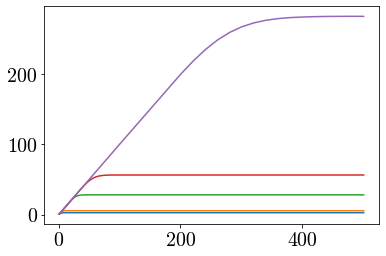

In [131]:
for i in range(Nf):
    plot(Ns,sr_[i])

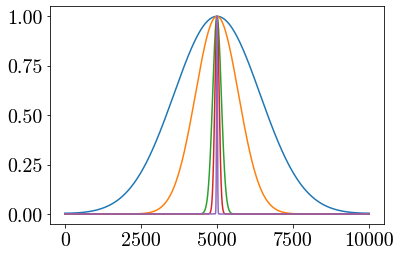

In [132]:
for i in range(Nf):
    plot(cr_[i])

In [133]:
sigs

[0.1, 0.05, 0.01, 0.005, 0.001]

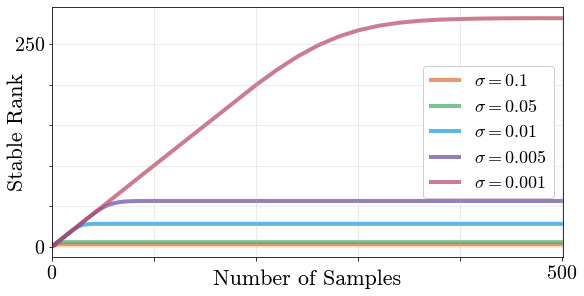

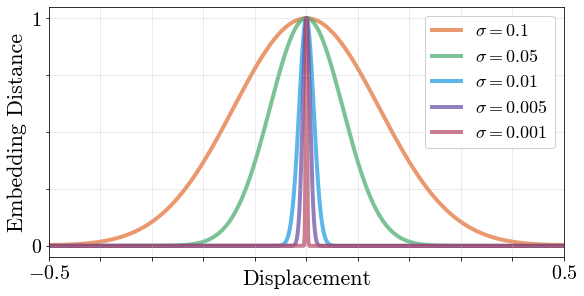

In [134]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     #[0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

names = ['$0.1$','$0.05$','$0.01$','$0.005$','$0.001$']


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(Nf):
    ax.plot(Ns,sr_[i],label='$\sigma=$'+names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks([0,50,100,150,200,250])
ax.set_yticklabels(['$0$','','','','','$250$'])
ax.set_xticks([0,100,200,300,400,500])
ax.set_xticklabels(['$0$','','','','','$500$'])
plt.xlabel('Number of Samples', labelpad=-13)
plt.ylabel('Stable Rank', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='center right',  ncol=1, framealpha=.95, handlelength=1.6)

#ax.set_title('(a) Stable Rank', y=title_offset)
plt.savefig(file_path+'Compare_gaussian_sr.pdf', bbox_inches='tight', pad_inches=0)

fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(Nf):
    ax.plot(np.linspace(0, 1, Large_D+1)[:-1].reshape(-1,1)-0.5,cr_[i],label='$\sigma=$'+names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.legend()

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks(np.linspace(0,1,5))
ax.set_yticklabels(['$0$']+['']+['']+['']+['$1$'])
ax.set_xticks(np.linspace(-0.5,0.5,11))
ax.set_xticklabels(['$-0.5$']+['']*4+['']+['']*4+['$0.5$'])
plt.xlabel('Displacement', labelpad=-13)
plt.ylabel('Embedding Distance')
plt.grid(True, which='both', alpha=.3)

ax.legend(loc='upper right',  ncol=1, framealpha=.95, handlelength=1.6)

#ax.set_title('(b) Distance Preservation', y=title_offset)

plt.savefig(file_path+'Compare_gaussian_dp.pdf', bbox_inches='tight', pad_inches=0)

In [121]:
Large_D = 100000
Ns = list(range(1,201,5))+list(range(201,551,50))
bs = [1,10,20,40,70]
Nf = len(bs)
sr_ = np.zeros((Nf,len(Ns)))
cr_ = np.zeros((Nf,Large_D))

In [122]:
for k in range(Nf):
    for tt in range(1):
        b = bs[k]*torch.randn((int(Large_D/2),1))
        x0 = torch.from_numpy(np.linspace(0, 1, Large_D+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
        all_emb = rff_embedding(x0,b)/np.sqrt(Large_D/2)
        for i in range(Large_D):
            cr_[k][i] = np.sum(all_emb[i]*all_emb[50000])
        for i in range(len(Ns)):
            x = torch.from_numpy(np.linspace(0, 1, Ns[i]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
            idx = (x*all_emb.shape[0]).int().squeeze()
            sr_[k][i] += srank_func(torch.from_numpy(all_emb[idx].reshape(-1,all_emb.shape[0])).type(torch.FloatTensor))

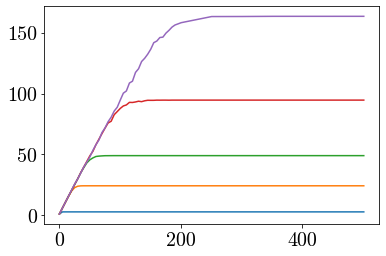

In [123]:
for i in range(Nf):
    plot(Ns,sr_[i]/1)

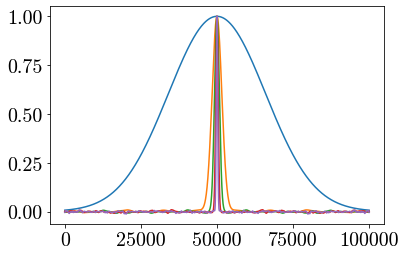

In [126]:
for i in range(Nf):
    plot(cr_[i])

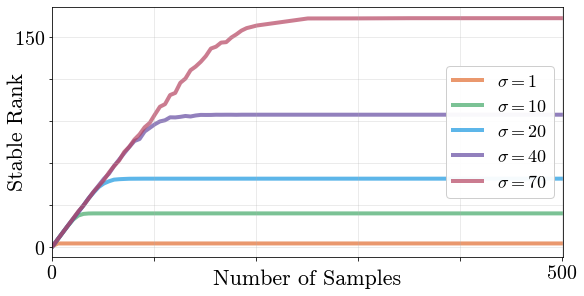

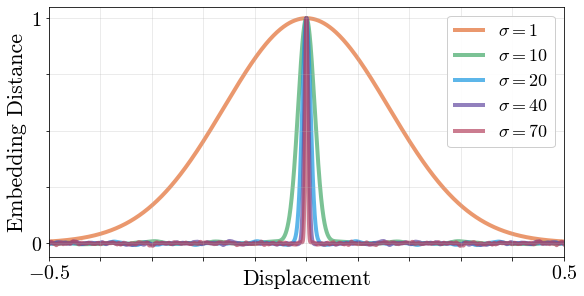

In [128]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 18,
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     #[0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

names = ['$1$','$10$','$20$','$40$','$70$']


fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(Nf):
    ax.plot(Ns,sr_[i]/1,label='$\sigma=$'+names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks([0,30,60,90,120,150])
ax.set_yticklabels(['$0$','','','','','$150$'])
ax.set_xticks([0,100,200,300,400,500])
ax.set_xticklabels(['$0$','','','','','$500$'])
plt.xlabel('Number of Samples', labelpad=-13)
plt.ylabel('Stable Rank', labelpad=-13)
plt.grid(True, which='both', alpha=.3)
ax.legend(loc='center right',  ncol=1, framealpha=.95, handlelength=1.6)

#ax.set_title('(a) Stable Rank', y=title_offset)
plt.savefig(file_path+'Compare_rff_sr.pdf', bbox_inches='tight', pad_inches=0)

fig1 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])
for i in range(Nf):
    ax.plot(np.linspace(0, 1, Large_D+1)[:-1].reshape(-1,1)-0.5,cr_[i],label='$\sigma=$'+names[i],color=colors_k[i], linewidth=linewidth, alpha=line_alpha, zorder=1)
plt.legend()

plt.autoscale(enable=True, axis='x', tight=True)
ax.set_yticks(np.linspace(0,1,5))
ax.set_yticklabels(['$0$']+['']+['']+['']+['$1$'])
ax.set_xticks(np.linspace(-0.5,0.5,11))
ax.set_xticklabels(['$-0.5$']+['']*4+['']+['']*4+['$0.5$'])
plt.xlabel('Displacement', labelpad=-13)
plt.ylabel('Embedding Distance')
plt.grid(True, which='both', alpha=.3)

ax.legend(loc='upper right',  ncol=1, framealpha=.95, handlelength=1.6)

#ax.set_title('(b) Distance Preservation', y=title_offset)

plt.savefig(file_path+'Compare_rff_dp.pdf', bbox_inches='tight', pad_inches=0)

In [5]:
Ds = [1000,2000,3000,5000]
N_samples = 100
sr_b = np.zeros((4,N_samples))
di_b = np.zeros((4,N_samples))

sr_f = np.zeros((4,N_samples))
di_f = np.zeros((4,N_samples))

for dd in range(4):
    
    rnd = np.random.rand(N_samples)
    sigs = 10**(rnd*2-3)

    for k in range(N_samples):
        sig = sigs[k]
        c = np.exp(-0.5*(np.linspace(0, 1, Ds[dd]+1)[:-1]-0.5)**2/sig**2)
        c = c/np.linalg.norm(c)
        all_emb = scipy.linalg.circulant(c)

        cr_ = np.zeros((Ds[dd],))
        for i in range(Ds[dd]):
            cr_[i] = np.sum(all_emb[i]*all_emb[int(Ds[dd]/2)])
        di_b[dd][k] = (cr_>0.1).sum()/Ds[dd]/2

        sr_b[dd][k] = srank_func(torch.from_numpy(all_emb).type(torch.FloatTensor))

    bs = 100**(rnd)

    for k in range(N_samples):
        b = bs[k]*torch.randn((int(Ds[dd]/2),1))
        x0 = torch.from_numpy(np.linspace(0, 1, Ds[dd]+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
        all_emb = rff_embedding(x0,b)/np.sqrt(Ds[dd]/2)

        cr_ = np.zeros((Ds[dd],))
        for i in range(Ds[dd]):
            cr_[i] = np.sum(all_emb[i]*all_emb[int(Ds[dd]/2)])
        di_f[dd][k] = (cr_>0.1).sum()/Ds[dd]/2

        sr_f[dd][k] = srank_func(torch.from_numpy(all_emb).type(torch.FloatTensor))

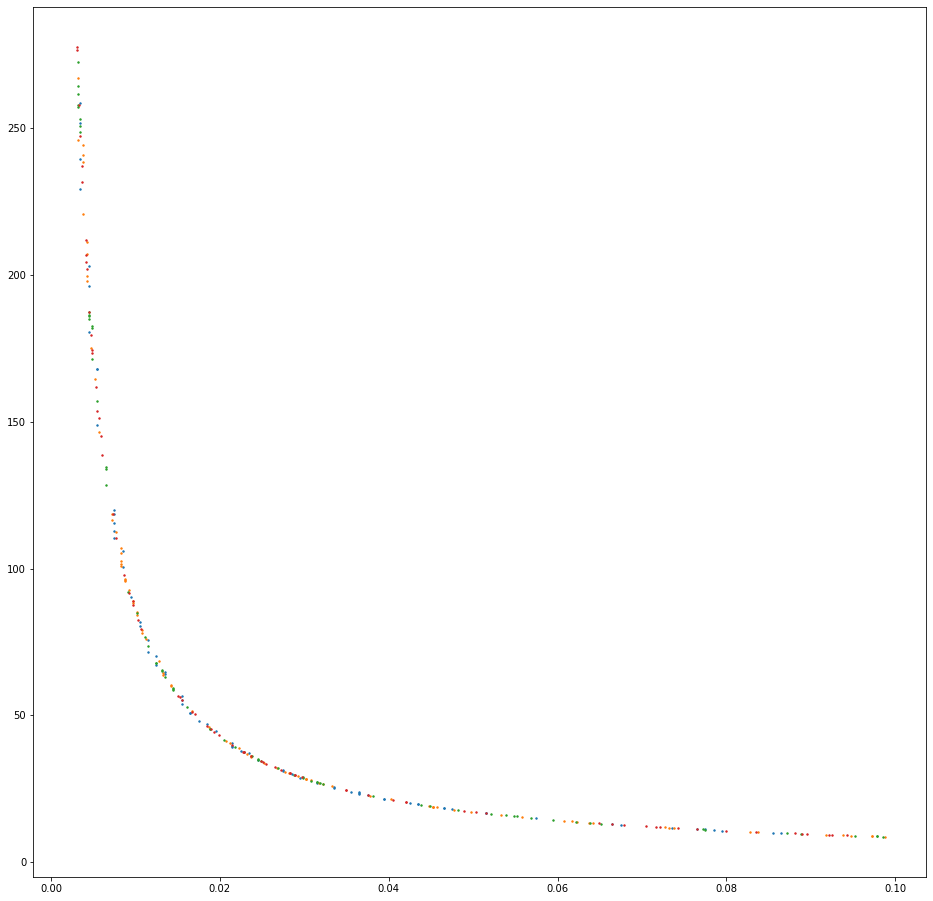

In [9]:
figure(figsize=(16,16))
for i in range(4):
    scatter(di_b[i,di_b[i]<0.1],sr_b[i,di_b[i]<0.1],s=2)

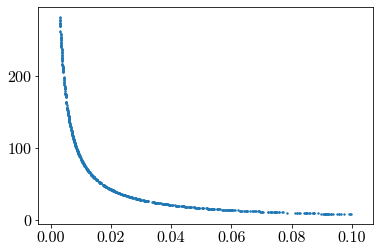

In [26]:
scatter(di_b[di_b<0.1],sr_b[di_b<0.1],s=2)
#scatter(di_f[di_f<0.1],sr_f[di_f<0.1],s=2)

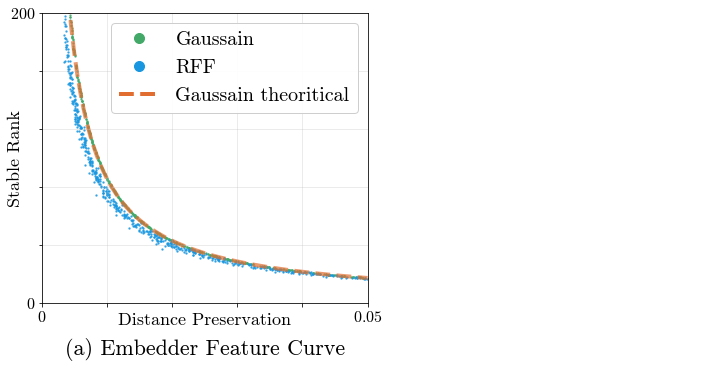

In [31]:
import matplotlib.patches as patches
import matplotlib.pylab as pylab
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

params = {'legend.fontsize': 20,
         'axes.labelsize': 18,
         'axes.titlesize': 22,
         'xtick.labelsize':16,
         'ytick.labelsize':16}
pylab.rcParams.update(params)


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["font.family"] = "cmr10"


colors_k = np.array([[0.8872, 0.4281, 0.1875],
     [0.8136, 0.6844, 0.0696],
    [0.2634, 0.6634, 0.4134],
    [0.0943, 0.5937, 0.8793],
    [0.3936, 0.2946, 0.6330],
    [0.7123, 0.2705, 0.3795]])
linewidth = 4
line_alpha = .7
title_offset = -0.2

names = ['$1$','$6$','$15$','$40$','$100$']


fig1 = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig1.add_gridspec(1, 1)
ax = fig1.add_subplot(gs[0, 0])

scatter(di_b,sr_b,s=2,label='Gaussain',color=colors_k[2], alpha=line_alpha, zorder=1)
scatter(di_f,sr_f,s=2,label='RFF',color=colors_k[3], alpha=line_alpha, zorder=1)
plot(np.linspace(0.001,0.05,100),np.sqrt(log(10)/np.pi)/np.linspace(0.001,0.05,100),'--',label='Gaussain theoritical',color=colors_k[0], linewidth=linewidth, alpha=line_alpha, zorder=1)


custom_lines = [Line2D([], [], color= colors_k[2], marker= '.',markersize = 20,linestyle='None'),
                    Line2D([], [], color= colors_k[3], marker= '.',markersize = 20,linestyle='None'),
                Line2D([], [], color=colors_k[0],linestyle='--', linewidth=linewidth)]

ax.legend(custom_lines, ['Gaussain', 'RFF','Gaussain theoritical'], loc='upper right',  ncol=1, framealpha=.95)

#plt.legend(loc='upper right', framealpha=.95)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim(top=200,bottom=0)
ax.set_xlim(right=0.03,left=0)
ax.set_yticks([0,40,80,120,160,200])
ax.set_yticklabels(['$0$','','','','','$200$'])
ax.set_xticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_xticklabels(['$0$','','','','','$0.05$'])
plt.xlabel('Distance Preservation', labelpad=-13)
plt.ylabel('Stable Rank', labelpad=-13)
plt.grid(True, which='both', alpha=.3)

ax.set_title('(a) Embedder Feature Curve', y=title_offset)

plt.savefig('SR_vs_DP.pdf', bbox_inches='tight', pad_inches=0)